## Useful links
- vgg16 keras implementation - https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
- another vgg16 keras implementation - https://github.com/SamSamskies/courses/blob/master/deeplearning1/nbs/vgg16.py
- keras model API - https://keras.io/models/model/
- nvidia model implementation - https://github.com/jacobgil/keras-steering-angle-visualizations
- vehicle steering angle visualizations blog post - https://jacobgil.github.io/deeplearning/vehicle-steering-angle-visualizations
- comma ai - https://github.com/commaai/research/blob/master/train_steering_model.py

In [228]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from random import randint
from imp import reload
import utils; reload(utils)

IMAGE_SHAPE = (100, 320, 3)
DATA_PATH = '../data/'

def save_model(model, model_filename, weights_filename):
    if Path(model_filename).is_file():
        os.remove(model_filename)

    with open(model_filename,'w' ) as f:
        json.dump(model.to_json(), f)
        
    if Path(weights_filename).is_file():
        os.remove(weights_filename)
        
    model.save_weights(weights_filename)
    

def get_commaai_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=IMAGE_SHAPE))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
              
    return model


def get_nvidia_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=IMAGE_SHAPE))
    model.add(Convolution2D(24, 5, 5, init = 'he_normal', subsample= (2, 2), name='conv1_1'))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, init = 'he_normal', subsample= (2, 2), name='conv2_1'))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5, init = 'he_normal', subsample= (2, 2), name='conv3_1'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample= (1, 1), name='conv4_1'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample= (1, 1), name='conv4_2'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1164, init = 'he_normal', name = "dense_0"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, init = 'he_normal',  name = "dense_1"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, init = 'he_normal', name = "dense_2"))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, init = 'he_normal', name = "dense_3"))
    model.add(Activation('relu'))
    model.add(Dense(1, init = 'he_normal', name = "dense_4"))

    model.compile(optimizer='adam', loss='mse')
              
    return model


def train_model(model, num_images):
    df = utils.augment_dataframe(pd.read_csv(DATA_PATH + 'driving_log.csv'))

    df_sample = df.sample(num_images)
    train_features = []
    train_labels = []

    for _, row in df_sample.iterrows():
        image_path = DATA_PATH + row.image.strip()
        train_features.append(utils.load_image(image_path, row.is_flipped))
        train_labels.append(row.steering)

    history = model.fit(np.array(train_features), np.array(train_labels), batch_size=10, nb_epoch=10, validation_split=0.2)
    save_model(model, '../model.json', '../model.h5')
    
    return history


# Didn't end up needing this
# def get_batch(df):
#     features = []
#     labels = []

#     for _, row in df.iterrows():
#         image_path = DATA_PATH + row.image.strip()
#         image = utils.load_image(image_path, row.is_flipped)
#         features.append(image)
#         labels.append(row.steering)
        
#     return (features, labels)

In [213]:
# model = get_commaai_model()
model = get_nvidia_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_37 (Lambda)               (None, 100, 320, 3)   0           lambda_input_37[0][0]            
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 48, 158, 24)   1824        lambda_37[0][0]                  
____________________________________________________________________________________________________
activation_82 (Activation)       (None, 48, 158, 24)   0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv2_1 (Convolution2D)          (None, 22, 77, 36)    21636       activation_82[0][0]              
___________________________________________________________________________________________

23364


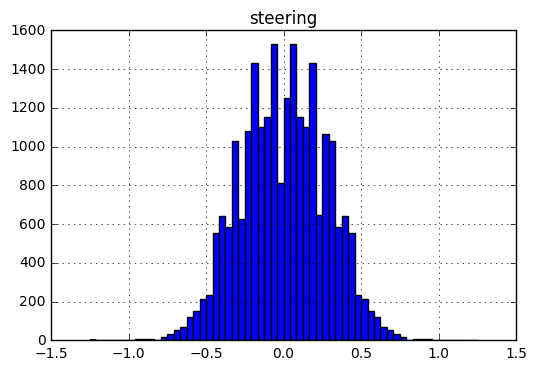

In [214]:
# TODO: 
# 1. Make utils file with dataframe augmentation functions and load image function
# 2. Load a small sample subset and train model and try running the simulation with it
# 3. Try to figure out how to make a generator to use with fit_generator
df = utils.augment_dataframe(pd.read_csv(DATA_PATH + 'driving_log.csv'))
df.hist(column='steering', bins=60)
df.head(20)
print(len(df))

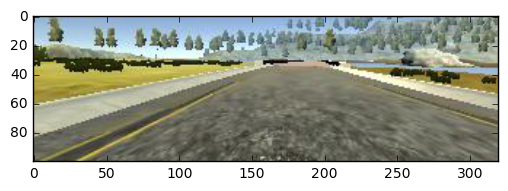

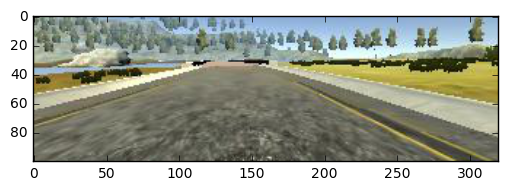

In [215]:
row = df.iloc[0]
image_path = DATA_PATH + row.image.strip()
test = utils.load_image(image_path, row.is_flipped)
plt.imshow(test)
plt.figure()
test = utils.load_image(image_path, True)
plt.imshow(test)

In [218]:
# try sample of images
df_sample = df.sample(100)
train_features = []
train_labels = []

for _, row in df_sample.iterrows():
    image_path = DATA_PATH + row.image.strip()
    train_features.append(utils.load_image(image_path, row.is_flipped))
    train_labels.append(row.steering)

In [219]:
history = model.fit(np.array(train_features), np.array(train_labels), batch_size=10, nb_epoch=1, validation_split=0.2)
save_model(model, '../model.json', '../model.h5')

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 6s - loss: 1.1398 - val_loss: 0.0599


In [187]:
# didn't need this
# try training with all the data
# for i, df_chunk in enumerate(np.array_split(df, 4)):
#     train_features, train_labels = get_batch(df_chunk)
#     history = model.fit(np.array(train_features), np.array(train_labels), batch_size=10, nb_epoch=10, validation_split=0.2)
#     save_model(model, '../model_{}.json'.format(i), '../model_{}.h5'.format(i))

In [229]:
model = get_nvidia_model()
num_images = 2000
train_model(model, num_images)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 72s - loss: 0.1900 - val_loss: 0.0602
Epoch 2/10
1600/1600 [==============================] - 69s - loss: 0.0632 - val_loss: 0.0449
Epoch 3/10
1600/1600 [==============================] - 69s - loss: 0.0528 - val_loss: 0.0396
Epoch 4/10
1600/1600 [==============================] - 94s - loss: 0.0435 - val_loss: 0.0396
Epoch 5/10
1600/1600 [==============================] - 119s - loss: 0.0416 - val_loss: 0.0294
Epoch 6/10
1600/1600 [==============================] - 120s - loss: 0.0393 - val_loss: 0.0311
Epoch 7/10
1600/1600 [==============================] - 122s - loss: 0.0341 - val_loss: 0.0294
Epoch 8/10
1600/1600 [==============================] - 123s - loss: 0.0320 - val_loss: 0.0325
Epoch 9/10
1600/1600 [==============================] - 121s - loss: 0.0285 - val_loss: 0.0289
Epoch 10/10
1600/1600 [==============================] - 132s - loss: 0.0284 - val_loss: 0.0315
